# Pacotes

In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Definir a seed para reprodutibilidade
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

initializer = tf.keras.initializers.GlorotUniform(seed=seed)

tf.config.experimental.enable_op_determinism()


# Importa Dados

In [2]:
# Carregar os dados
data = pd.read_csv("PETR4.SA.csv")

# ERRATA: a correção anteriormente sugerida por meio do sort_values altera
# a estrutura do DataFrame e não fica compatível com o treinamento e teste
# da série temporal. A correção será feita na função shift da célula abaixo.

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-14,29.170000,29.670000,28.719999,29.450001,23.936726,50745400
1,2021-01-15,29.049999,29.080000,28.030001,28.120001,22.855711,80673300
2,2021-01-18,28.309999,28.850000,28.010000,28.070000,22.815071,68855700
3,2021-01-19,28.480000,28.860001,27.639999,28.690001,23.319004,61656000
4,2021-01-20,28.950001,29.120001,28.110001,28.209999,22.928862,60306200
...,...,...,...,...,...,...,...
244,2022-01-10,27.990000,28.240000,27.719999,28.010000,28.010000,37455200
245,2022-01-11,28.100000,29.070000,27.850000,28.990000,28.990000,62315600
246,2022-01-12,28.950001,29.910000,28.950001,29.719999,29.719999,81378200
247,2022-01-13,29.530001,30.629999,29.500000,30.320000,30.320000,76717500


# Cria DF

In [4]:
# Criar as features e o target
fechamento = data["Close"].values
fechamento_anterior = data['Close'].shift(1)

# CORREÇÃO: o shift foi alterado de -1 para 1.
# Desta forma, a defasagem de X em relação a Y fica adequada.

data_analise = pd.DataFrame({"fechamento": fechamento, "fechamento_anterior": fechamento_anterior})
data_analise.dropna(inplace=True)

In [5]:
data_analise

,fechamento,fechamento_anterior
1,28.120001,29.450001
2,28.070000,28.120001
3,28.690001,28.070000
4,28.209999,28.690001
5,27.549999,28.209999
...,...,...
244,28.010000,28.180000
245,28.990000,28.010000
246,29.719999,28.990000
247,30.320000,29.719999


# Pré-processamento

In [6]:
# Normalizar os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(data_analise["fechamento_anterior"].values.reshape(-1, 1))
Y = scaler.fit_transform(data_analise["fechamento"].values.reshape(-1, 1))

In [7]:
# Dividir em conjunto de treinamento e teste
train_size = 150
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [8]:
# Reshape dos dados para RNN
x_train_rnn = X_train.reshape(10, 15, 1)
y_train_rnn = Y_train.reshape(10, 15, 1)
# Test set
x_test_rnn = X_test.reshape(1, 98, 1)
y_test_rnn = Y_test.reshape(1, 98, 1)

In [9]:
X.shape

(248, 1)

# Modelo LSTM

In [10]:
# Definir a semente para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [11]:
# Criar o modelo LSTM
model = Sequential([
    LSTM(units=20, activation = 'relu', return_sequences=True, input_shape=(15, 1)),
    Dense(units=10, activation = 'linear'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compila e Treina

In [12]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compilar modelo
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Treinar o modelo
history = model.fit(x_train_rnn, y_train_rnn, epochs=1000, verbose=1)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2676
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2664
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2651
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2639
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2626
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2614
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2601
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2589
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2577
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2564
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2552
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2540
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2528
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2516
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2504
Epoch 

# Predição

In [13]:
# Avaliar o modelo
Y_train_pred = model.predict(x_train_rnn)
Y_test_pred = model.predict(x_test_rnn)

# Desnormalizar os dados - previstos
Y_train_pred = Y_train_pred.reshape(Y_train_pred.shape[0],Y_train_pred.shape[1])
Y_train_pred = scaler.inverse_transform(Y_train_pred)

Y_test_pred = Y_test_pred.reshape(Y_test_pred.shape[0],Y_test_pred.shape[1])
Y_test_pred = scaler.inverse_transform(Y_test_pred)

# Desnormalizar os dados - valores reais
y_train_real = y_train_rnn.reshape(y_train_rnn.shape[0], y_train_rnn.shape[1])
y_test_real = y_test_rnn.reshape(y_test_rnn.shape[0], y_test_rnn.shape[1])

y_train_real = scaler.inverse_transform(y_train_real)
y_test_real = scaler.inverse_transform(y_test_real)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


In [14]:
np.ravel(Y_test_pred)

array([24.666124, 26.007484, 26.973253, 27.505651, 28.101368, 28.366571,
       28.070667, 27.705606, 27.20611 , 26.703148, 26.370943, 25.575525,
       25.246666, 24.973442, 25.149101, 25.1706  , 25.390392, 25.482592,
       25.1412  , 24.826237, 24.828157, 25.074108, 25.61779 , 26.029522,
       26.414808, 26.615412, 26.903835, 27.028679, 27.384491, 27.901196,
       28.477133, 28.571878, 28.60237 , 28.786278, 28.959364, 29.177208,
       29.327517, 29.3841  , 29.348436, 28.740246, 28.51918 , 27.934593,
       27.453234, 27.874512, 28.059399, 28.202944, 28.428028, 27.8816  ,
       27.86947 , 27.394547, 26.761864, 26.292015, 26.097105, 26.189045,
       26.197104, 26.242712, 26.498688, 26.790459, 26.740356, 26.699602,
       26.497496, 26.4562  , 26.961538, 27.513279, 28.362751, 28.515375,
       28.99042 , 29.265049, 29.492912, 29.134365, 29.016352, 28.945425,
       29.062336, 29.125956, 29.143787, 29.293907, 29.319244, 29.19887 ,
       29.186813, 29.327456, 29.14417 , 28.697699, 

In [15]:
from sklearn.metrics import r2_score

r2_score(np.ravel(y_test_real), np.ravel(Y_test_pred))

0.5981918509375252

# Gráfico

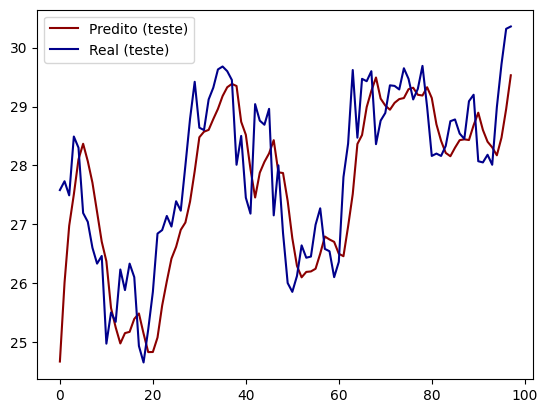

In [16]:
# Plotar resultados
plt.plot(np.ravel(Y_test_pred), label='Predito (teste)', color='darkred')
plt.plot(np.ravel(y_test_real), label='Real (teste)', color='darkblue')
plt.legend()
plt.show()